In [198]:
class Client:
    def __init__(self, description):
        description_split = description.split('\t')
        self.entered = int(description_split[0])
        self.went_to_operator = int(description_split[1])
        self.done = int(description_split[2])
        
    def __str__(self):
        line = str(self.entered) + '\t'
        line += str(self.went_to_operator) + '\t'
        line += str(self.done) + '\t'
        return line
    
class BranchingProcess:
    def __init__(self):
        self.operators = 0
        self.service = []
        
    def __str__(self):
        line = ''
        for i in range(len(self.service)):
            line += str(i) + '\t'    
            line += str(self.service[i]) + '\n'
        return line

def read_from_files(files):
    processes = []
    for file_path in files:
        processes.append(BranchingProcess())
        with open(file_path) as file_in:
            for line in file_in:
                if (line[0] == '#'):
                    splited = line.split(' ')
                    processes[-1].operators = int(splited[4])
                elif (line[0] != 'a'):
                    processes[-1].service.append(Client(line))

    return processes


In [199]:

import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
from collections import Counter
from datetime import date, timedelta,datetime

%matplotlib inline


In [200]:
F = ['0', '1', '2', '3', '4']
F = map(lambda x:  'office_'+ x,F)
F = list(F)
Processes = read_from_files(F)

In [201]:
service_data = []

for proc in Processes:
    one_comp = []
    for s in proc.service:
        waiting = s.went_to_operator - s.entered
        servicing = s.done - s.went_to_operator
        one_comp.append([waiting, servicing])
    service_data.append(one_comp)
    

In [203]:
def plot(sd, proc):
    plt.figure(figsize=(15,7))
    for cl in proc.service:
        index =proc.service.index(cl) 
        X1 = np.arange(cl.entered, cl.went_to_operator, 1)
        Y1 = np.zeros(len(X1))
        X2 = np.arange(cl.went_to_operator, cl.done, 1)
        Y2 = np.zeros(len(X2))
        plt.plot(X1, Y1 + index, c='r')
        plt.plot(X2, Y2 + index, c='g')    

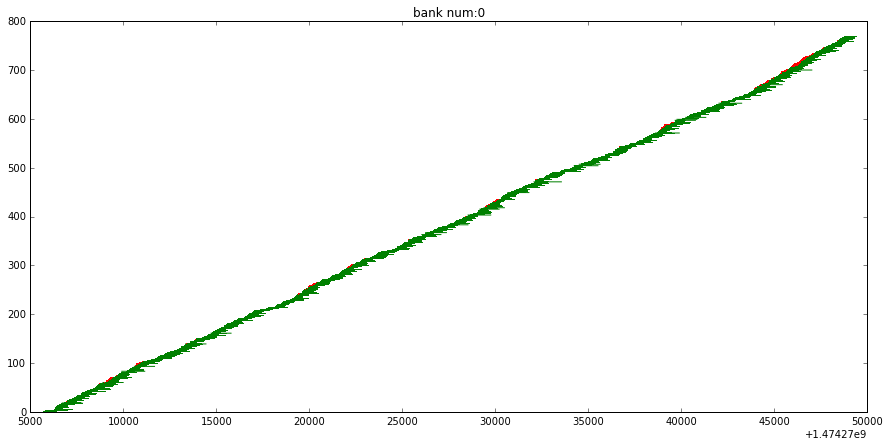

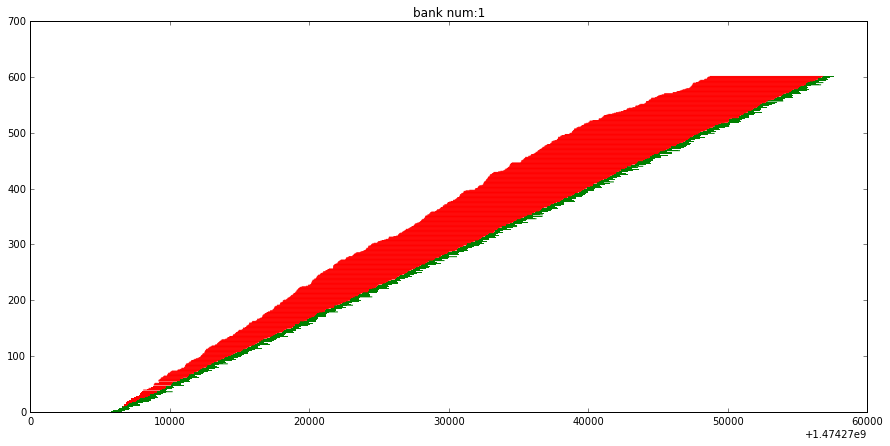

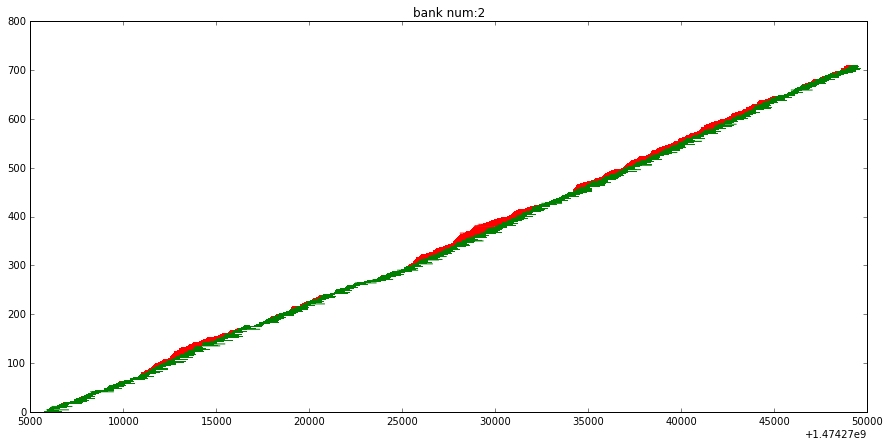

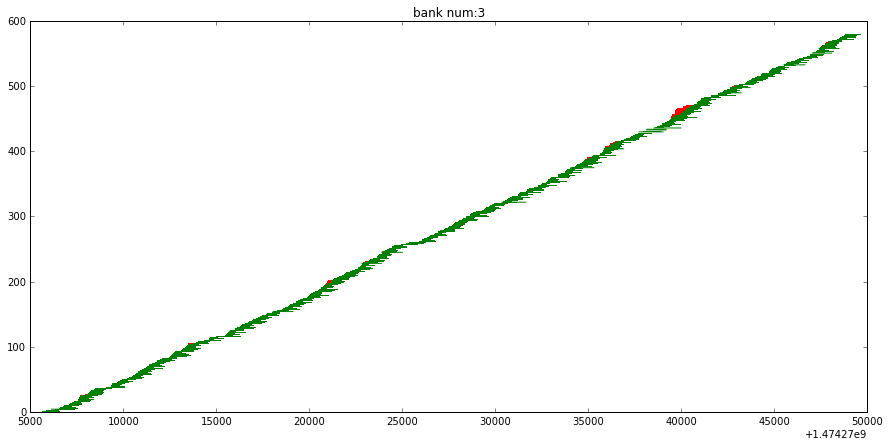

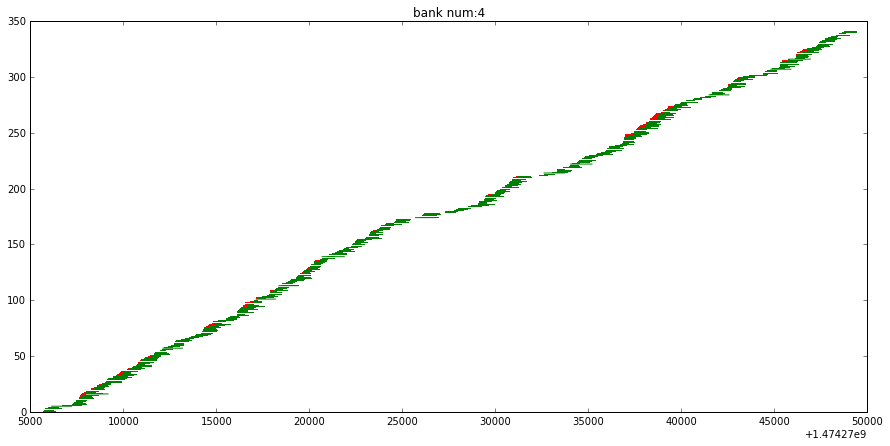

In [204]:
for i in range(len(Processes)):
    plot(service_data[i],Processes[i])
    plt.title("bank num:"+ str(i))
    plt.show()

Оценим распределение как гамма

(8.3303143688045864, -2.0396599024164166, 70.363808464722737)


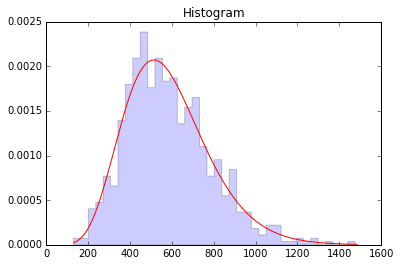

Вероятность того, что гамма распределение подходит к полученным данным: 0.000000

Mean 584.112987013


(6.7024622338566129, 78.026566100320736, 76.92442769784904)


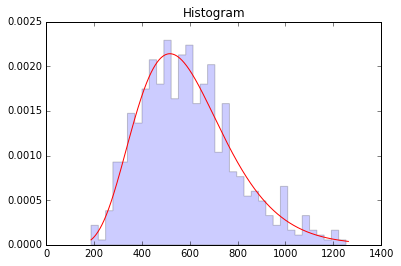

Вероятность того, что гамма распределение подходит к полученным данным: 0.000000

Mean 593.609634551


(11.802368200834996, -109.98025424910422, 60.95190883854157)


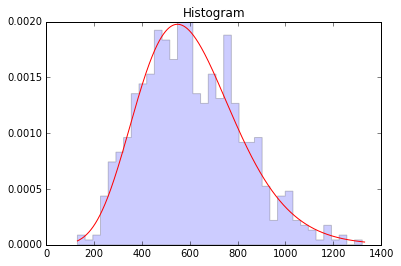

Вероятность того, что гамма распределение подходит к полученным данным: 1.000000

Mean 609.396624473


(8.3415421230595523, 14.298360425965233, 70.657005294503364)


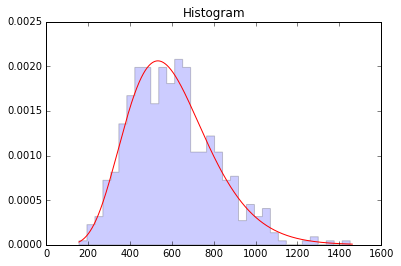

Вероятность того, что гамма распределение подходит к полученным данным: 1.000000

Mean 603.686746988


(12.204317333619162, -60.896106284495964, 55.78709986395431)


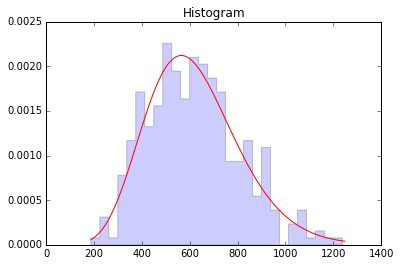

Вероятность того, что гамма распределение подходит к полученным данным: 1.000000

Mean 619.947368421




In [11]:
import scipy.stats as ss
import math

def hi_2(latencies):
    latencies = np.sort(latencies)[:1000]
    import math
    bins_number = round(10+math.sqrt(len(latencies)))
    plt.title("Histogram")
    
    k = np.mean(latencies)**2 / np.var(latencies)

    plt.hist(latencies, bins_number, normed=True,
             histtype='stepfilled', alpha=0.2)  
    print(ss.gamma.fit(latencies, k))
     
    x = np.linspace(np.min(latencies),
                    np.max(latencies) + 10, len(latencies) * 2)
     
    shape, loc, lambd = ss.gamma.fit(latencies, k)     
    distr_data = ss.gamma.pdf(x, shape, loc=loc, scale=lambd)
    plt.plot(x, distr_data, 'r')
    plt.show()
    
    counts, bins = np.histogram(latencies, bins=bins_number)
    p_observed = np.array(counts, dtype=float)

    tmp = ss.gamma.pdf(bins, shape, loc=loc, scale=lambd)
    p_expected = []
    for idx, p in enumerate(tmp):
        if idx == len(tmp) - 1: break
        p_expected.append(tmp[idx+1] - tmp[idx])

    p_expected = (len(latencies))*np.array(p_expected)

    chi_test_value, probability_fit = 
            ss.chisquare(p_observed, np.array(p_expected,
                                              dtype=float))
    print('Вероятность того, что гамма '+
          'распределение подходит: {0:f}'.format(probability_fit))
serv_means = []
for i in range(5):
    X  = np.array(service_data[:][i])[:,1]
    hi_2(X)
    serv_means.append(np.mean(X))
    print("\nMean "+str(serv_means[i])+"\n\n")

На мой взгляд, неплохо получилось.

In [95]:
lambdas = []
for proc in Processes:
    X = []
    for i in range(1,len(proc.service)):
        X.append(proc.service[i].entered -
                 proc.service[i-1].entered)
    lambdas.append(1/np.mean(X))
print(lambdas) 

[0.017858801672085461, 0.013989106652390485, 0.01646109616989706, 0.01344335249397367, 0.0079149548545830138]


Оценка максимального правдоподобия $\lambda = \frac{1}{\bar{x}}$ для каждого из банков

In [177]:
def show_interval(l, proc, average_serv):
    alpha = 0.95
    m = proc.operators
    T = [cl.entered for cl in proc.service]
    minT = np.min(T)
    T = [t - minT for t in T]
    counter = 0
    Y = []
    
    for t in T:
        counter += 1
        Y.append(counter)
    
    fig = plt.figure(figsize=(15, 7))
    
    ax = fig.gca()
    
    min_y = [ss.poisson.ppf( [1/2 - alpha/2, 1/2 + alpha/2], l*T[i])[0] 
             for i in range(len(T))]
    max_y = [ss.poisson.ppf( [1/2 - alpha/2, 1/2 + alpha/2], l*T[i])[1] 
             for i in range(len(T))]
    
    plt.fill_between(T,min_y, max_y, alpha = 0.05, color= 'b')

    
    min_X = [min_y[i] - T[i]*m/average_serv for i in range(len(T))]
    max_X = [max_y[i] - (T[i]- average_serv)*m/average_serv 
             for i in range(len(T))]
    
    plt.fill_between(T,min_X, max_X, alpha = 0.03 , color='y')

    plt.plot(T, Y, c = 'r')
    

    
    def mnk_val(x,y):
        B = np.array(y)
        A = np.array(([[x[j], 1] for j in range(len(x))]))
        X = np.linalg.lstsq(A,B)[0]
        return X[0]
    
    delta_m = 0
                
    if (mnk_val(T,max_X) > 0):
        for i in range (m):
            delta_m += 1
            max_X = [max_y[i] - 
                     (T[i]
                      - average_serv)*(m+delta_m)/average_serv 
                     for i in range(len(T))]
            if (mnk_val(T,max_X) < 0):
                print('number of operators should increase to '
                      +str(m+delta_m) + ' from ' + str(m))
                min_X = [min_y[i] - 
                         T[i]*(m+delta_m)/average_serv 
                         for i in range(len(T))]
                print(mnk_val(T,max_X))
                plt.fill_between(T,min_X, max_X, alpha = 0.03 , 
                                 color='r')
                break

    elif (mnk_val(T,max_X) < 0):
        for i in range (m):
            delta_m -= 1
            max_X = [max_y[i] - 
                     (T[i]- average_serv)*(m+delta_m)/average_serv
                     for i in range(len(T))]
            if (mnk_val(T,max_X) > 0):
                delta_m += 1
                print('number of operators can be reduced to '
                      +str(m+delta_m) + ' from ' + str(m))
                min_X = [min_y[i] - 
                         T[i]*(m+delta_m)/average_serv 
                         for i in range(len(T))]
                print(mnk_val(T,max_X))
                max_X = [max_y[i] - 
                         (T[i]- average_serv)*(m+delta_m)/average_serv
                         for i in range(len(T))]
                plt.fill_between(T,min_X, max_X, alpha = 0.03 , color='r')
                break
            
    plt.show()

Intervals for bank 0
number of operators can be reduced to 12 from 13
3.16207292035e-05


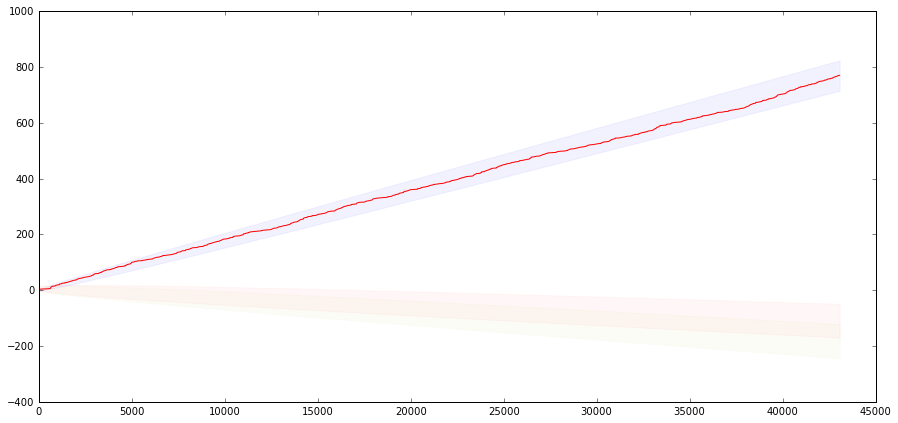

Intervals for bank 1
number of operators should increase to 9 from 7
-0.000257749778368


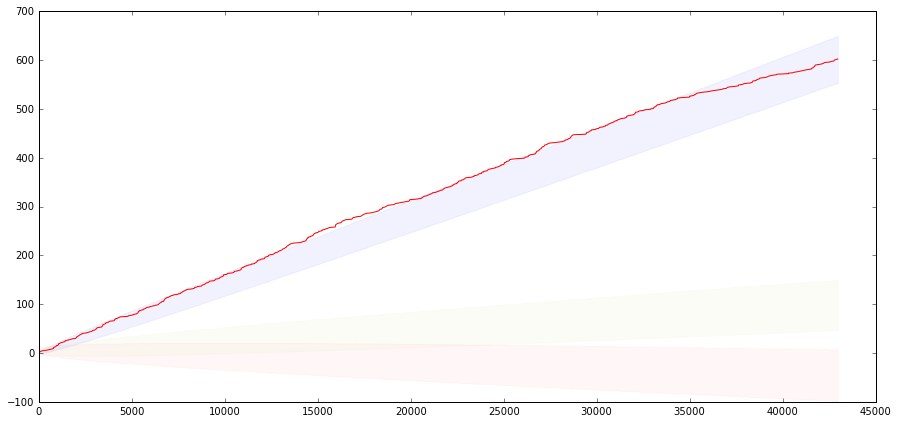

Intervals for bank 2
number of operators can be reduced to 11 from 11
0.00102221664268


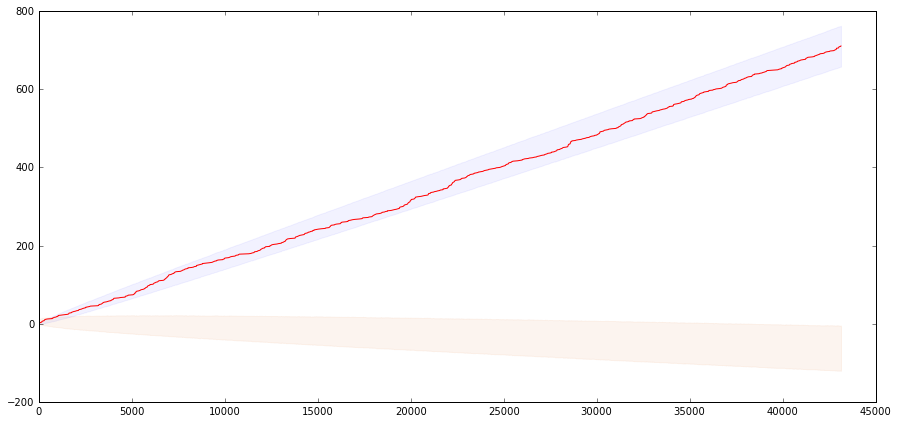

Intervals for bank 3
number of operators can be reduced to 9 from 12
0.00105590517228


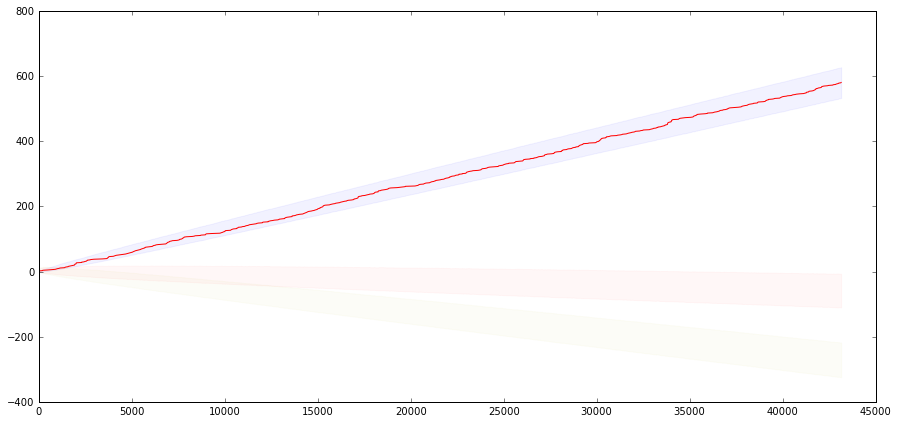

Intervals for bank 4
number of operators can be reduced to 6 from 7
0.000524164197301


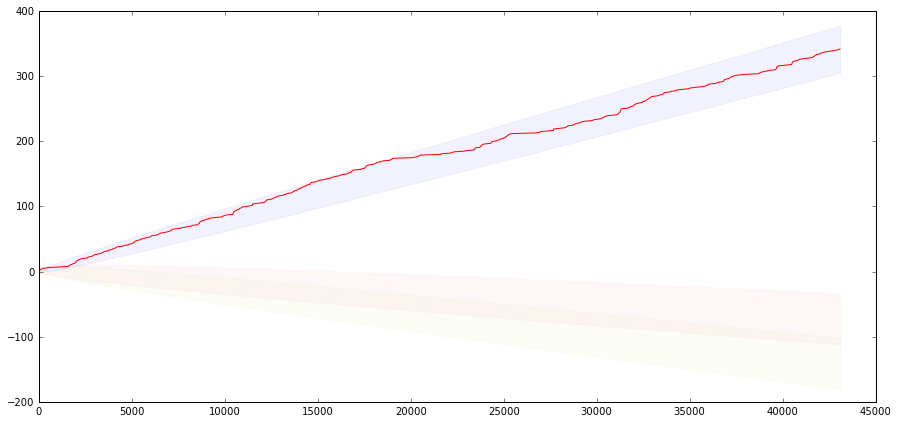

In [178]:
for i in range(5):
    print("Intervals for bank "+ str(i))
    show_interval(lambdas[i], Processes[i],serv_means[i])

Оценивая угол наклона верхней границы интервала методом наименьших квадратов,

получим, что в нулевом офисе можно уменьшить количество операторов до 12 (-1),

во 1м увеличить до 9 (+2), во 2м оставить то, что есть сейчас, в 3м уменьшить 

до 9 (-3), в 4м до 6 (-1), чтобы верхняя граница перестала возрастать.

In [195]:
def count_operators(l, proc, average_serv):
    alpha = 0.95
    m = proc.operators
    T = [cl.entered for cl in proc.service]
    minT = np.min(T)
    T = [t - minT for t in T]
    counter = 0
    Y = []
    
    for t in T:
        counter += 1
        Y.append(counter)
    
    fig = plt.figure(figsize=(15, 7))
    
    ax = fig.gca()
    
    min_y = [ss.poisson.ppf( [1/2 - alpha/2, 1/2 + alpha/2],
                            l*T[i])[0]
             for i in range(len(T))]
    max_y = [ss.poisson.ppf( [1/2 - alpha/2, 1/2 + alpha/2], 
                            l*T[i])[1]
             for i in range(len(T))]
    
    
    mean_X = [1/2*((min_y[i] - T[i]*m/average_serv) + 
                  (max_y[i] - (T[i]- average_serv)*m/average_serv))
              for i in range(len(T))]
    
    plt.plot(T, mean_X, c = 'r')
    

    
    def mnk_val(x,y):
        B = np.array(y)
        A = np.array(([[x[j], 1] for j in range(len(x))]))
        X = np.linalg.lstsq(A,B)[0]
        return X[0]
    
    delta_m = 0
    print(mnk_val(T,mean_X))
    if (mnk_val(T,mean_X) > 0):
        for i in range (m):
            delta_m += 1
            mean_X = [1/2*((min_y[i] - T[i]*(m+delta_m)/average_serv) +
                           (max_y[i] - (T[i]- average_serv)*
                            (m+delta_m)/average_serv)) 
                      for i in range(len(T))]
            print(mnk_val(T,mean_X))
            if (mnk_val(T,mean_X) < 0):
                print('number of operators should increase to '
                      +str(m+delta_m) + ' from ' + str(m))
                plt.plot(T, mean_X, c = 'g',alpha = 0.3)
                break

    elif (mnk_val(T,mean_X) < 0):
        for i in range (m):
            delta_m -= 1
            mean_X = [1/2*((min_y[i] - T[i]*(m+delta_m)/average_serv) + 
                  (max_y[i] - (T[i]- average_serv)*
                   (m+delta_m)/average_serv))
                      for i in range(len(T))]
            if (mnk_val(T,mean_X) > 0):
                delta_m += 1
                print('number of operators can be reduced to '
                      +str(m+delta_m)
                      + ' from ' + str(m))
                mean_X = [1/2*((min_y[i] - T[i]*(m+delta_m)/average_serv) + 
                  (max_y[i] - (T[i]- average_serv)*(m+delta_m)/average_serv)) 
                          for i in range(len(T))]
                plt.plot(T, mean_X, c = 'g', alpha = 0.3)
                break
            
    plt.show()

Intervals for bank 0
-0.00439717713626
number of operators can be reduced to 11 from 13


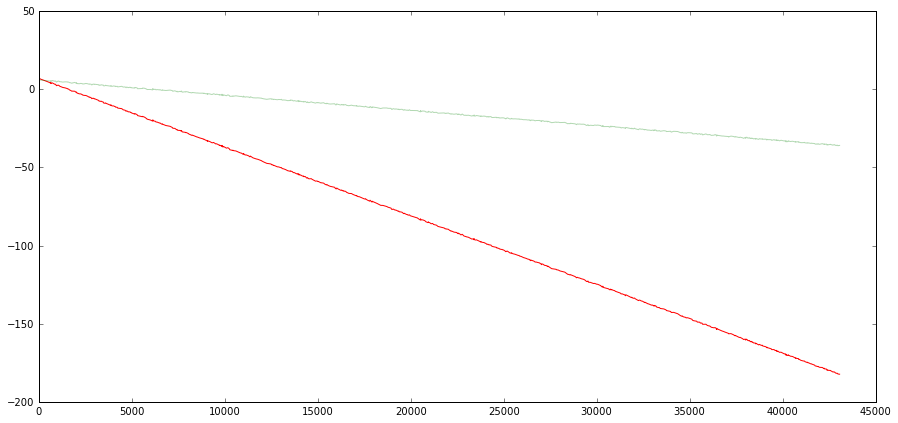

Intervals for bank 1
0.00219632100984
0.000511712233641
-0.00117289654256
number of operators should increase to 9 from 7


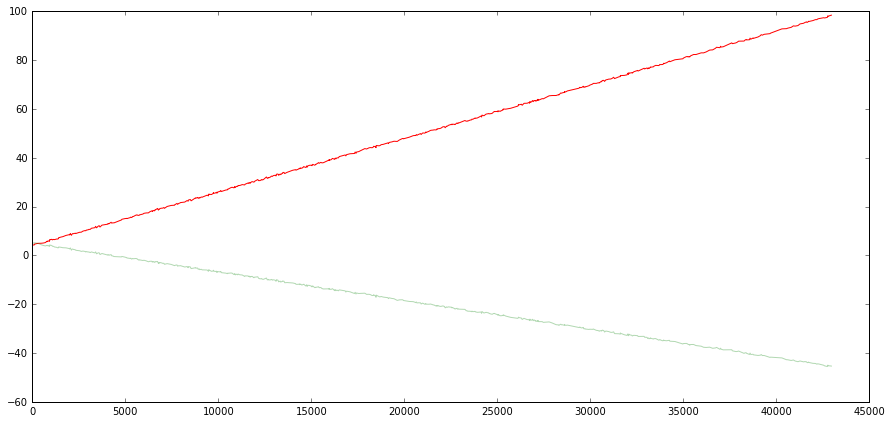

Intervals for bank 2
-0.00159029539768
number of operators can be reduced to 11 from 11


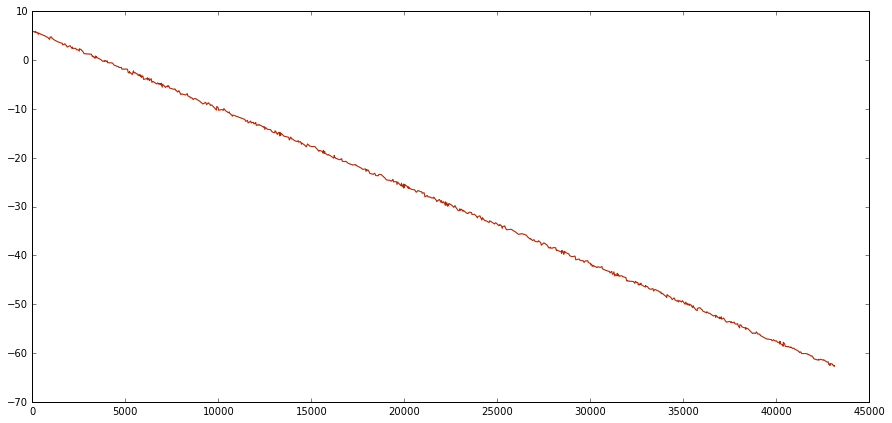

Intervals for bank 3
-0.0064352361836
number of operators can be reduced to 9 from 12


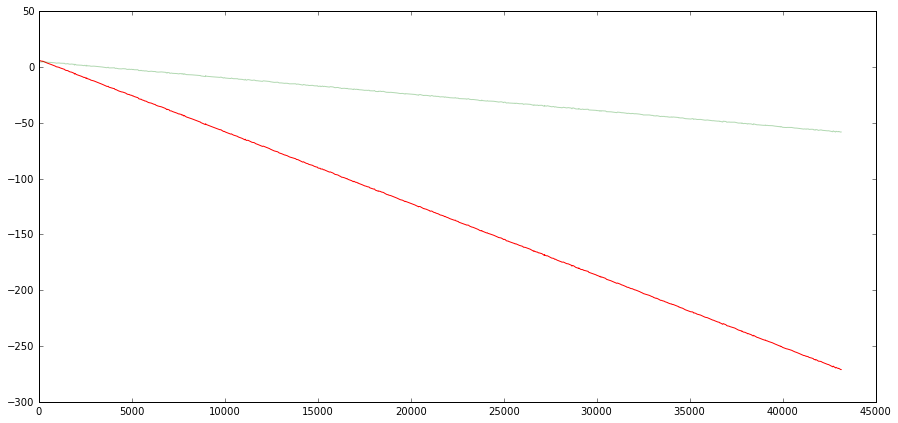

Intervals for bank 4
-0.00337549003528
number of operators can be reduced to 5 from 7


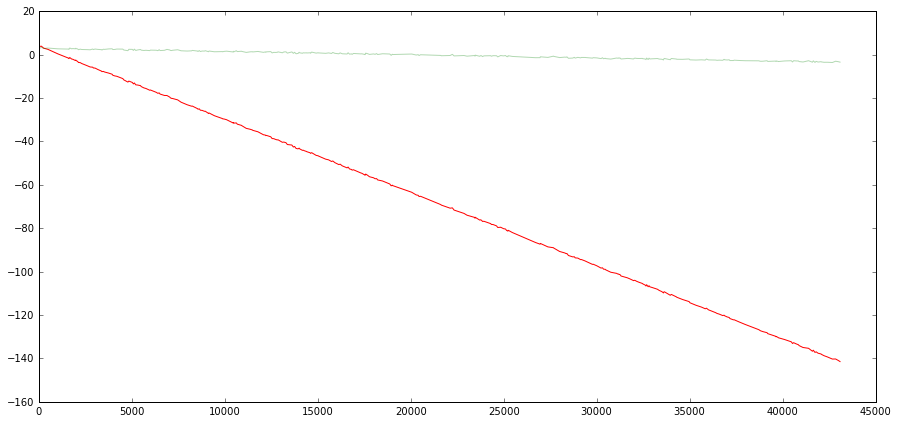

In [196]:
for i in range(5):
    print("Intervals for bank "+ str(i))
    count_operators(lambdas[i], Processes[i],serv_means[i])

Оценивая угол наклона среднего границ интервала методом наименьших квадратов, получим,

что в нулевом офисе можно уменьшить количество операторов до 11 (-2), во 1м увеличить 


до 9 (+2), во 2м оставить то, что есть сейчас, в 3м уменьшить  до 9 (-3), в 4м до 5 (-2), 

чтобы верхняя граница перестала возрастать.

Учитывая, что у нас 5 лишних операторов, раздадим всем банкам, 

тогда даже верхняя граница всех интервалов будет убывать

Собственно, раздав операторов как написано под графиками с интервалами,

можно себе позволить не ставить стулья с вероятностью 95%, так как верхняя 

граница доверительного интервала для X_t  будет ниже нуля